In [1]:
import pandas as pd
import numpy as np
import folium
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib.colors as mcolors
from plotly import graph_objects as go
from sklearn.cluster import KMeans
import warnings
import re
from typing import Tuple

# 경고 메시지 무시 설정
warnings.filterwarnings('ignore')

# Pandas 설정
pd.set_option('display.max_columns', None)

%reload_ext autotime

time: 205 μs (started: 2024-07-29 04:05:34 +09:00)


In [2]:
# 위치 데이터를 numpy 배열로 변환
def generate_kmeans_clusters(longitude: pd.Series, latitude: pd.Series, n_clusters: int=6) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Generate KMeans clusters from longitude and latitude data."""
    locations = np.column_stack((longitude, latitude))
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(locations)
    cluster_centers = kmeans.cluster_centers_
    labels = kmeans.labels_
    return locations, cluster_centers, labels

def visualize_with_folium(locations: np.ndarray, cluster_centers: np.ndarray, labels: np.ndarray) -> folium.Map:
    """Visualize clustered data with Folium"""
    # Folium 지도 생성
    m = folium.Map(location=[36.5, 127.5], zoom_start=7)
    colors = list(mcolors.TABLEAU_COLORS.values())
    for idx, row in enumerate(locations):
        cluster_color = colors[labels[idx] % len(colors)]
        folium.CircleMarker(location=[row[1], row[0]], radius=3, color=cluster_color, fill=True, fill_color=cluster_color, fill_opacity=0.6).add_to(m)
    for center in cluster_centers:
        folium.Marker(location=[center[1], center[0]], icon=folium.Icon(color='red', icon='info-sign')).add_to(m)
    m.save('clustered_location_data_folium.html')
    return m

def visualize_with_plotly(locations: np.ndarray, cluster_centers: np.ndarray, labels: np.ndarray) -> None:
    """Visualize clustered data with Plotly Express"""
    df = pd.DataFrame(locations, columns=['Longitude', 'Latitude'])
    df['Cluster'] = labels
    fig = px.scatter_mapbox(
        df,
        lat='Latitude',
        lon='Longitude',
        color='Cluster',
        zoom=5,
        mapbox_style="carto-positron",
        title='Clustered Location Data'
    )
    cluster_center_df = pd.DataFrame(cluster_centers, columns=['Longitude', 'Latitude'])
    fig.add_trace(
        go.Scattermapbox(
            lat=cluster_center_df['Latitude'],
            lon=cluster_center_df['Longitude'],
            mode='markers',
            marker=go.scattermapbox.Marker(
                size=14,
                color='red',
                symbol='cross'
            ),
            showlegend=False
        )
    )
    fig.show()

time: 1 ms (started: 2024-07-29 04:05:34 +09:00)


In [3]:
def get_season(date: pd.Timestamp) -> str:
    if date.month in (3, 4, 5):
        return '봄'
    elif date.month in (6, 7, 8):
        return '여름'
    elif date.month in (9, 10, 11):
        return '가을'
    else:
        return '겨울'

time: 210 μs (started: 2024-07-29 04:05:34 +09:00)


In [4]:
# 0. 데이터 전처리
# 여행객 데이터와 방문지 정보를 불러오기
traveler_master = pd.read_csv('./total/여행객 Master.csv')
traveler_master['계절'] = traveler_master['TRAVEL_STATUS_YMD'].apply(lambda x: pd.to_datetime(x.split('~')[0])).apply(get_season)

visit_info = pd.read_csv('./total/방문지정보.csv', dtype={'X_COORD': str, 'Y_COORD': str})
visit_info['계절'] = pd.to_datetime(visit_info['VISIT_START_YMD']).apply(get_season)
travel = pd.read_csv('./total/여행.csv')

time: 1.16 s (started: 2024-07-29 04:05:34 +09:00)


1. **위도, 경도** 값이 없는 일부 데이터들의 값들을 채움
2. '올레길', '올레길 주차장' 처럼 **달리 표기된 장소를 하나로** 통일
3. 방문지에서 **사적 장소**(집, 친구/친지집, 사무실), **기타**(편의점, 피시방, 사우나 등)은 데이터에서 배제
   - codeB를 이용해서 完
   - 논의해야 할 점
     - 기타를 포함할지?
     - 역, 터미널, 고속도로 휴게소를 포함할지?(선행 제주도 프로젝트에서는 포함한 것으로 보임)
4. **식당**이면 RES, **관광지**면 TOU로 데이터 구분
   - codeB를 이용해서 code 10(식당)이 아니면 TOU로 넣으면 될 것 같음
   - but, 다른 code Num을 갖는 것들 중 예외 처리 필요 있음(상업지구, 상점, 지역축제 등)

In [5]:
visit_pre = pd.read_csv('./total/방문지정보.csv')

# 12: 기타, 21: 집, 22: 친구/친지집, 23: 사무실
del_area_type = {12, 21, 22, 23}

# 사적 장소 제거
visit_pre = visit_pre[~visit_pre['VISIT_AREA_TYPE_CD'].isin(del_area_type)]
# 식당, 관광지 구분
visit_pre['VISIT_AREA_TYPE_CD'] = visit_pre['VISIT_AREA_TYPE_CD'].apply(lambda x: 'RES' if x == 10 else 'TOU')

# 여행 데이터와 방문지 정보를 여행ID(TRAVEL_ID)를 기준으로 합치기
visit_data = pd.merge(travel, visit_info, on='TRAVEL_ID')
# 위 데이터를 여행객 마스터와 합치기 (TRAVEL_ID)를 기준으로
visit_final = pd.merge(visit_data, traveler_master, on='TRAVELER_ID')

travel_pre = pd.merge(travel, traveler_master, on='TRAVELER_ID', how='inner')

time: 285 ms (started: 2024-07-29 04:05:35 +09:00)


In [6]:
travel_pre

,TRAVEL_ID,TRAVEL_NM,TRAVELER_ID,TRAVEL_PURPOSE,TRAVEL_START_YMD,TRAVEL_END_YMD,MVMN_NM,TRAVEL_PERSONA,TRAVEL_MISSION,TRAVEL_MISSION_CHECK,region_x,RESIDENCE_SGG_CD,GENDER,AGE_GRP,EDU_NM,EDU_FNSH_SE,MARR_STTS,FAMILY_MEMB,JOB_NM,JOB_ETC,INCOME,HOUSE_INCOME,TRAVEL_TERM,TRAVEL_NUM,TRAVEL_LIKE_SIDO_1,TRAVEL_LIKE_SGG_1,TRAVEL_LIKE_SIDO_2,TRAVEL_LIKE_SGG_2,TRAVEL_LIKE_SIDO_3,TRAVEL_LIKE_SGG_3,TRAVEL_STYL_1,TRAVEL_STYL_2,TRAVEL_STYL_3,TRAVEL_STYL_4,TRAVEL_STYL_5,TRAVEL_STYL_6,TRAVEL_STYL_7,TRAVEL_STYL_8,TRAVEL_STATUS_RESIDENCE,TRAVEL_STATUS_DESTINATION,TRAVEL_STATUS_ACCOMPANY,TRAVEL_STATUS_YMD,TRAVEL_MOTIVE_1,TRAVEL_MOTIVE_2,TRAVEL_MOTIVE_3,TRAVEL_COMPANIONS_NUM,region_y,계절
0,e_e000004,E03,e000004,3,2023-04-30,2023-05-01,NaN,서울 외 수도권 방문/수도권 거주/40세 이상/자녀동반/일반미션,3,3;4;11,capital,41,남,40,6,1.0,2,3,2,NaN,7,8.0,2,1,50,50110,42,42210,42,42170,5,3,5,4,5,4,2,5,경기도,경기,자녀 동반 여행,2023-04-29~2023-04-30,1,3.0,NaN,2,capital,봄
1,e_e000006,E03,e000006,21,2023-04-30,2023-05-02,NaN,경기 방문/거주지 구분 없음/39세 이하/특별미션,21,21;10;27,capital,11,남,30,7,1.0,1,1,3,NaN,5,NaN,3,4,26,26350,26,26710,50,50110,3,3,2,4,5,4,3,2,서울특별시,경기,2인 가족 여행,2023-04-30~2023-05-01,1,2.0,3.0,1,capital,봄
2,e_e000009,E03,e000009,2;4,2023-04-29,2023-05-01,NaN,서울 외 수도권 방문/수도권 거주/39세 이하/커플/일반미션,2;4,22;1;7,capital,28,여,30,5,1.0,1,3,3,NaN,4,12.0,2,1,42,42150,11,11440,41,41650,3,2,3,3,2,6,4,7,인천광역시,경기,2인 여행(가족 외),2023-04-29~2023-04-30,3,1.0,2.0,1,capital,봄
3,e_e000010,E01,e000010,3;6,2023-04-29,2023-05-01,NaN,서울 방문/수도권 외 거주/39세 이하/나홀로 여행/일반미션,3;6,6;3;1,capital,48,여,30,6,1.0,1,2,3,NaN,4,4.0,2,2,11,11710,11,11440,26,26350,5,4,3,2,5,4,5,3,경상남도,서울,나홀로 여행,2023-04-29~2023-04-30,8,1.0,2.0,0,capital,봄
4,e_e000011,E01,e000011,1;21,2023-04-28,2023-05-01,NaN,서울 방문/수도권 외 거주/40세 이상/커플/일반미션,1;21,6;2;24,capital,48,여,60,7,1.0,2,1,2,NaN,7,NaN,2,1,48,48220,11,11560,26,26710,3,3,3,4,2,4,6,6,경상남도,서울,3인 이상 여행(가족 외),2023-04-28~2023-04-30,3,7.0,1.0,3,capital,봄
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7675,g_g013127,G06,g013127,1;10;2;23,2023-09-27,2023-09-28,NaN,충청권 방문/충청권 거주/39세 이하/나홀로 여행/일반미션,1;10;2;23,1;2;3,western,43,여,30,6,1.0,1,1,3,NaN,4,NaN,3,5,42,42210,11,11680,44,44270,2,2,1,4,2,4,3,3,충청북도,충남,나홀로 여행,2023-09-27~2023-09-27,7,2.0,6.0,0,western,가을
7676,g_g013128,G04,g013128,21;22;24;3;6,2023-09-29,2023-09-30,NaN,전남 방문/거주지 구분 없음/39세 이하/특별미션,21;22;24;3;6,6;1;21,western,29,여,20,6,2.0,1,1,12,NaN,1,NaN,3,3,50,50110,11,11680,30,30170,4,6,5,3,4,3,7,5,광주광역시,대전,나홀로 여행,2023-09-29~2023-09-29,1,2.0,8.0,0,western,가을
7677,g_g013131,G03,g013131,2;21;22;26;4,2023-09-29,2023-09-30,NaN,전남 방문/거주지 구분 없음/39세 이하/특별미션,2;21;22;26;4,4;22;21,western,29,남,20,6,1.0,1,2,13,NaN,1,8.0,2,1,11,11440,26,26500,50,50130,6,3,2,3,3,6,6,6,광주광역시,전남,2인 여행(가족 외),2023-09-29~2023-09-29,5,3.0,2.0,1,western,가을
7678,h_h001459,G05,h001459,22,2023-07-06,2023-07-08,대중교통 등,충북 방문/거주지 구분 없음/39세 이하/특별미션,22,22;5;26,western,11,남,30,7,2.0,1,3,12,NaN,4,12.0,2,1,50,50130,26,26350,11,11680,4,2,2,3,2,5,1,7,서울특별시,제주,2인 가족 여행,2023-07-07~2023-07-09,7,3.0,NaN,1,western,여름


time: 12.4 ms (started: 2024-07-29 04:05:35 +09:00)


In [7]:
visit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79165 entries, 0 to 79164
Data columns (total 35 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   TRAVEL_ID             79165 non-null  object 
 1   TRAVEL_NM             79165 non-null  object 
 2   TRAVELER_ID           79165 non-null  object 
 3   TRAVEL_PURPOSE        79165 non-null  object 
 4   TRAVEL_START_YMD      79165 non-null  object 
 5   TRAVEL_END_YMD        79165 non-null  object 
 6   MVMN_NM               72737 non-null  object 
 7   TRAVEL_PERSONA        79165 non-null  object 
 8   TRAVEL_MISSION        79165 non-null  object 
 9   TRAVEL_MISSION_CHECK  79165 non-null  object 
 10  region_x              79165 non-null  object 
 11  VISIT_AREA_ID         79165 non-null  int64  
 12  VISIT_ORDER           79165 non-null  int64  
 13  VISIT_AREA_NM         79165 non-null  object 
 14  VISIT_START_YMD       79165 non-null  object 
 15  VISIT_END_YMD      

In [8]:
visit_final = visit_info.copy()

def is_numeric(value):
    if pd.isna(value):
        return False
    return bool(re.match(r'^[0-9.]+$', value))

print(visit_final[~visit_final['X_COORD'].apply(is_numeric)]['X_COORD'].unique())
print(visit_final[~visit_final['Y_COORD'].apply(is_numeric)]['Y_COORD'].unique())

[nan]
[nan]
time: 85.6 ms (started: 2024-07-29 04:05:35 +09:00)


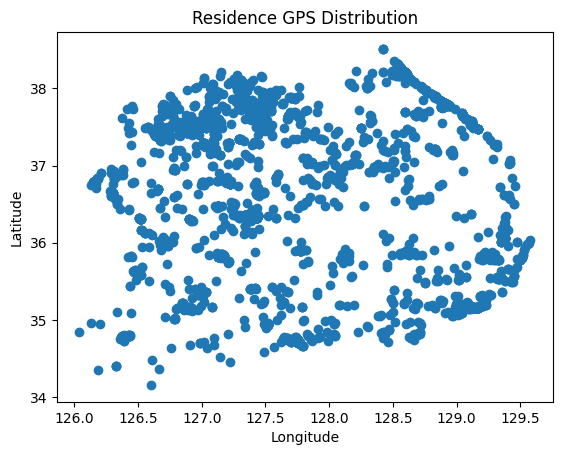

time: 202 ms (started: 2024-07-29 04:05:35 +09:00)


In [9]:
# VISIT_AREA_TYPE_CD가 24인 행 필터링
visit_final_lodging = visit_final[visit_final['VISIT_AREA_TYPE_CD'] == 24]

# VISIT_AREA_TYPE_CD가 21 또는 22인 행 필터링하여 추가
rows_with_home = visit_final[visit_final['VISIT_AREA_TYPE_CD'].isin([21, 22])]
visit_final_lodging = pd.concat([visit_final_lodging, rows_with_home], ignore_index=True)

# 여행 ID가 중복되는 행 제거
visit_final_lodging = visit_final_lodging.drop_duplicates(subset=['TRAVEL_ID'])

# X_COORD와 Y_COORD를 float 타입으로 변환
visit_final_lodging['X_COORD'] = visit_final_lodging['X_COORD'].astype(float)
visit_final_lodging['Y_COORD'] = visit_final_lodging['Y_COORD'].astype(float)

# 대한민국 경계 좌표
kor_boundary = {'min_lon': 124.5, 'max_lon': 132.0, 'min_lat': 33.0, 'max_lat': 38.9}

# 경계 좌표 내에 있는 데이터만 선택
filtered_data = visit_final_lodging[
    (visit_final_lodging['X_COORD'].between(kor_boundary['min_lon'], kor_boundary['max_lon'])) &
    (visit_final_lodging['Y_COORD'].between(kor_boundary['min_lat'], kor_boundary['max_lat']))
]

# 데이터프레임에서 경도와 위도 추출
longitude = filtered_data['X_COORD']
latitude = filtered_data['Y_COORD']

# 시각화
plt.scatter(longitude, latitude)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Residence GPS Distribution')
plt.show()

In [10]:
# 지도 생성
m = folium.Map(location=[36.5, 127.5], zoom_start=7)

# 데이터 추가
for idx, row in filtered_data.iterrows():
    folium.Marker([row['Y_COORD'], row['X_COORD']]).add_to(m)

# 지도 표시
m.save('residence_gps_distribution.html')
m

time: 856 ms (started: 2024-07-29 04:05:36 +09:00)


In [11]:
# Plotly Express로 시각화
fig = px.scatter_mapbox(
    filtered_data,
    lat='Y_COORD',
    lon='X_COORD',
    zoom=5,
    mapbox_style="carto-positron",
    title='Residence GPS Distribution'
)

fig.show()

time: 186 ms (started: 2024-07-29 04:05:36 +09:00)


In [12]:
locations, cluster_centers, labels = generate_kmeans_clusters(longitude, latitude)

time: 146 ms (started: 2024-07-29 04:05:37 +09:00)


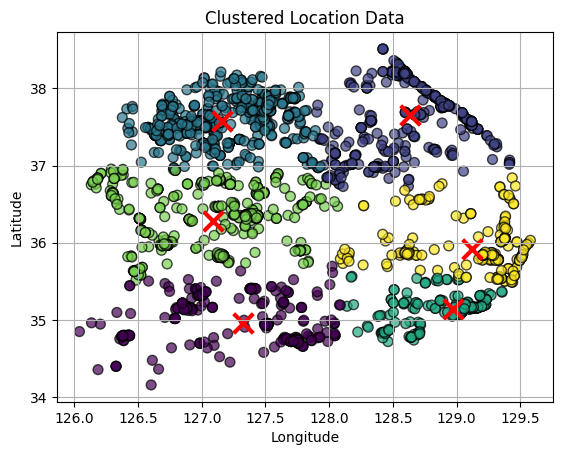

time: 206 ms (started: 2024-07-29 04:05:37 +09:00)


In [13]:
# 클러스터링 결과 시각화
plt.scatter(locations[:, 0], locations[:, 1], c=labels, cmap='viridis', marker='o', edgecolor='k', s=50, alpha=0.7)
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker='x', c='red', s=200, linewidths=3)
plt.title('Clustered Location Data')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

In [14]:
visualize_with_folium(locations, cluster_centers, labels)

time: 863 ms (started: 2024-07-29 04:05:37 +09:00)


In [15]:
visualize_with_plotly(locations, cluster_centers, labels)

time: 73.8 ms (started: 2024-07-29 04:05:38 +09:00)
